
# Breast Cancer Diagnosis on WBCD — ML + Calibration + DCA + DNN + XAI 


This notebook implements, step-by-step, a full pipeline on the **Wisconsin Breast Cancer Diagnostic (WBCD)** dataset:
- Baselines (LR/RF) with **Nested Cross-Validation**
- **ROC & PR** curves
- **Probability Calibration** (Platt & Isotonic) with **Reliability Curves** and **Brier Score**
- **Decision Curve Analysis (DCA)**
- **DNN** (Keras preferred; sklearn MLP fallback)
- **XAI**: **SHAP** (for RF; permutation importance fallback) and **LIME** (for DNN; single instance)




## 1) Setup & Imports

In [4]:

# Core scientific stack
import sys, warnings, os, random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Scikit-learn core
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay,
    precision_recall_curve, average_precision_score, brier_score_loss
)
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay
from sklearn.inspection import permutation_importance

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier

# Reproducibility
SEED = 42
np.random.seed(SEED)
random.seed(SEED)
warnings.filterwarnings('ignore')

# Environment report (useful for debugging)
print('Python:', sys.version.split()[0])
import sklearn, matplotlib
print('numpy:', np.__version__)
print('pandas:', pd.__version__)
print('sklearn:', sklearn.__version__)
print('matplotlib:', matplotlib.__version__)

# Try TensorFlow/Keras (optional); we will fallback if not available
try:
    import tensorflow as tf
    from tensorflow import keras
    TF_AVAILABLE = True
    print('tensorflow:', tf.__version__)
except Exception:
    TF_AVAILABLE = False
    print('tensorflow not available -> will fallback to sklearn MLP for the DNN section.')


Python: 3.10.18
numpy: 1.26.4
pandas: 2.3.1
sklearn: 1.7.1
matplotlib: 3.10.5
tensorflow: 2.20.0


## 2) Load WBCD & Target Preparation

In [9]:

# Load WBCD from sklearn
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y = pd.Series(data.target, name='target')  # in sklearn: 0=malignant, 1=benign

# Map to 1=malignant, 0=benign for clinical clarity
y = y.map({0:1, 1:0})

# For EDA convenience
df = X.copy()
df['target'] = y

print('Shape:', X.shape)
print('Malignant (1) count:', int((y==1).sum()))
print('Benign (0) count:', int((y==0).sum()))


Shape: (569, 30)
Malignant (1) count: 212
Benign (0) count: 357


## 3) Exploratory Data Analysis (EDA) — Balance, Missingness, Correlations, Top-6 Distributions

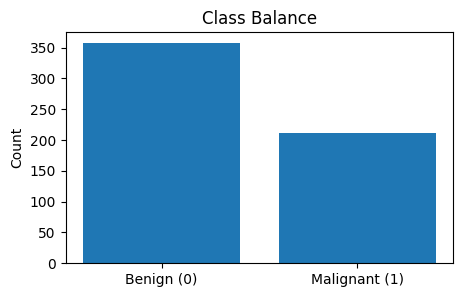

Top missing columns (expect zeros):
mean radius                0
concavity error            0
worst fractal dimension    0
worst symmetry             0
worst concave points       0
worst concavity            0
worst compactness          0
worst smoothness           0
worst area                 0
worst perimeter            0
dtype: int64


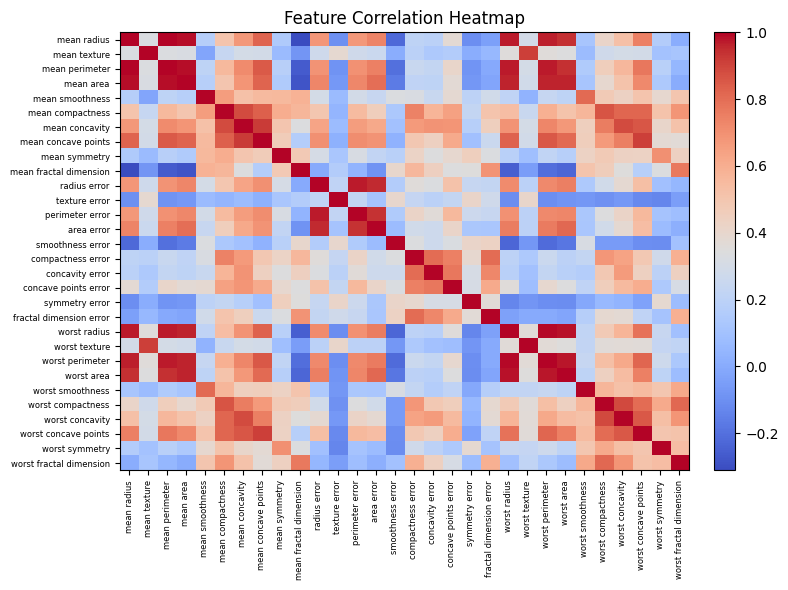

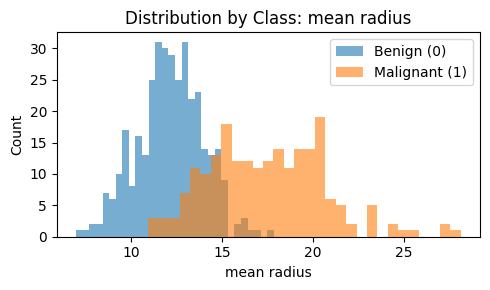

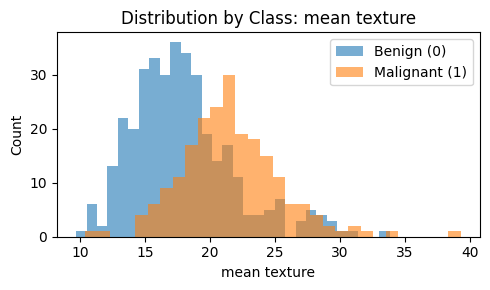

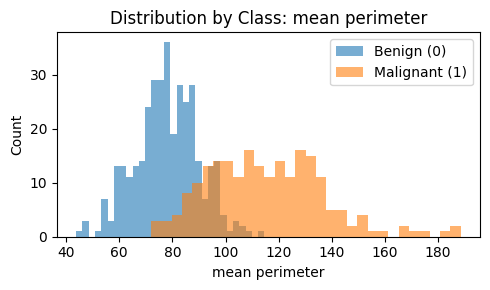

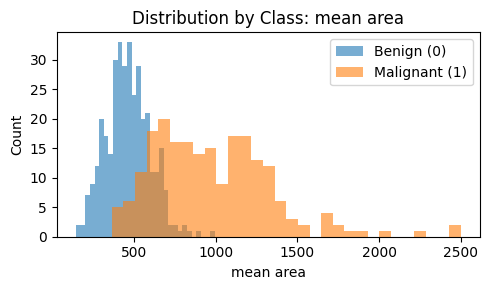

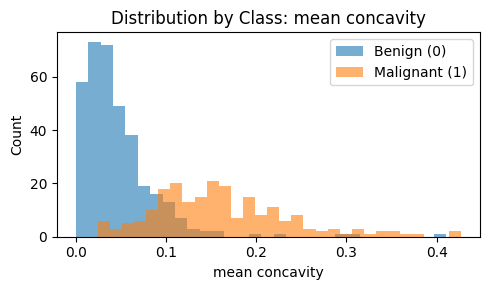

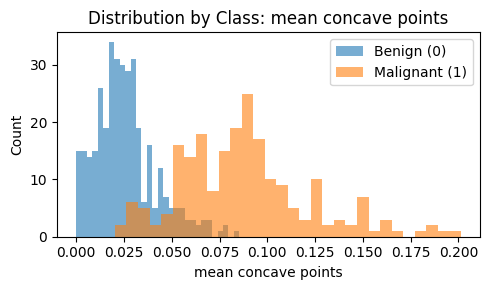

In [14]:

# Class balance
cls_counts = df['target'].value_counts().sort_index()
plt.figure(figsize=(5,3))
plt.bar(['Benign (0)', 'Malignant (1)'], [cls_counts[0], cls_counts[1]])
plt.title('Class Balance')
plt.ylabel('Count')
plt.show()

# Missingness check
missing = df.isna().sum().sort_values(ascending=False)
print('Top missing columns (expect zeros):')
print(missing.head(10))

# Correlation heatmap (matplotlib only)
corr = X.corr()
plt.figure(figsize=(8,6))
im = plt.imshow(corr, interpolation='nearest', aspect='auto', cmap='coolwarm') 
plt.title('Feature Correlation Heatmap')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=6)
plt.yticks(range(len(corr.index)), corr.index, fontsize=6)
plt.tight_layout()
plt.show()


# Top-6 discriminative features (commonly useful on WBCD)
top6 = ['mean radius','mean texture','mean perimeter','mean area','mean concavity','mean concave points']

for feat in top6:
    plt.figure(figsize=(5,3))
    plt.hist(df[df['target']==0][feat], bins=30, alpha=0.6, label='Benign (0)')
    plt.hist(df[df['target']==1][feat], bins=30, alpha=0.6, label='Malignant (1)')
    plt.xlabel(feat)
    plt.ylabel('Count')
    plt.title(f'Distribution by Class: {feat}')
    plt.legend()
    plt.tight_layout()
    plt.show()


## 4) Baselines (LR/RF) with Nested Cross-Validation + Test Metrics & Confusion Matrices

LR nested CV ROC-AUC: 0.9960 ± 0.0047
RF nested CV ROC-AUC: 0.9881 ± 0.0070
Best LR params: {'clf__C': 1.0, 'clf__penalty': 'l1'}
Best RF params: {'clf__max_depth': 10, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}
[LogisticRegression] Acc=0.974  Prec=0.976  Rec=0.952  F1=0.964  ROC-AUC=0.996


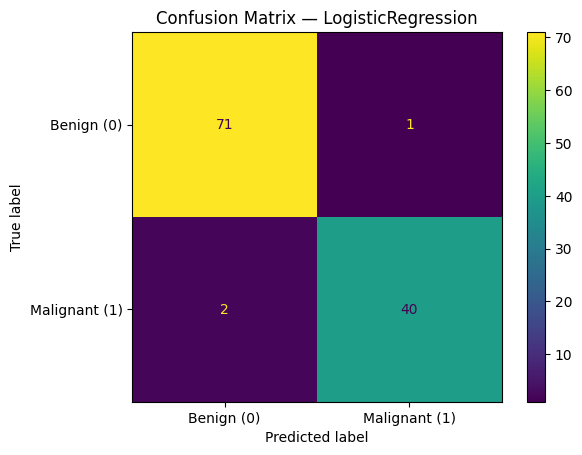

[RandomForest] Acc=0.974  Prec=1.000  Rec=0.929  F1=0.963  ROC-AUC=0.993


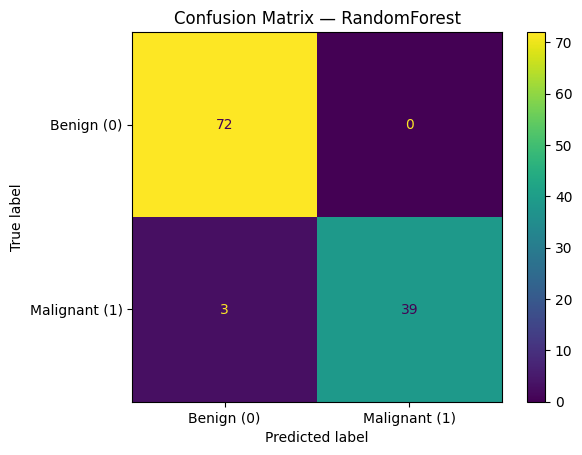

In [13]:

# Train/test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=SEED, stratify=y
)

# Pipelines
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=500, random_state=SEED, solver='liblinear'))
])

pipe_rf = Pipeline([
    ('clf', RandomForestClassifier(random_state=SEED))
])

# Hyperparameter grids
param_grid_lr = {
    'clf__C': [0.01, 0.1, 1.0, 10.0],
    'clf__penalty': ['l1', 'l2']
}

param_grid_rf = {
    'clf__n_estimators': [100, 300, 600],
    'clf__max_depth': [None, 5, 10],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2]
}

def nested_cv_report(pipe, param_grid, X, y, outer_splits=5, inner_splits=3, scoring='roc_auc'):
    """Run nested CV and return mean±std ROC-AUC; also keep fitted inner estimators for inspection."""
    outer_cv = StratifiedKFold(n_splits=outer_splits, shuffle=True, random_state=SEED)
    inner_cv = StratifiedKFold(n_splits=inner_splits, shuffle=True, random_state=SEED)
    grid = GridSearchCV(pipe, param_grid=param_grid, cv=inner_cv, scoring=scoring, n_jobs=-1)
    cv_results = cross_validate(grid, X, y, cv=outer_cv, scoring=scoring, n_jobs=-1, return_estimator=True)
    mean_auc = cv_results['test_score'].mean()
    std_auc = cv_results['test_score'].std()
    return mean_auc, std_auc, cv_results['estimator']

# Nested CV for LR and RF
lr_mean, lr_std, lr_estimators = nested_cv_report(pipe_lr, param_grid_lr, X_train, y_train)
rf_mean, rf_std, rf_estimators = nested_cv_report(pipe_rf, param_grid_rf, X_train, y_train)

print(f'LR nested CV ROC-AUC: {lr_mean:.4f} ± {lr_std:.4f}')
print(f'RF nested CV ROC-AUC: {rf_mean:.4f} ± {rf_std:.4f}')

# Refit best models on full training (inner CV)
best_lr = GridSearchCV(pipe_lr, param_grid_lr, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
                       scoring='roc_auc', n_jobs=-1).fit(X_train, y_train)
best_rf = GridSearchCV(pipe_rf, param_grid_rf, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED),
                       scoring='roc_auc', n_jobs=-1).fit(X_train, y_train)

print('Best LR params:', best_lr.best_params_)
print('Best RF params:', best_rf.best_params_)

def evaluate_on_test(name, model, X_test, y_test):
    """Evaluate a fitted classifier on test set and plot confusion matrix."""
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:,1]
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc = roc_auc_score(y_test, y_prob)
    print(f'[{name}] Acc={acc:.3f}  Prec={prec:.3f}  Rec={rec:.3f}  F1={f1:.3f}  ROC-AUC={roc:.3f}')
    cm = confusion_matrix(y_test, y_pred, labels=[0,1])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Benign (0)','Malignant (1)'])
    disp.plot(values_format='d')
    plt.title(f'Confusion Matrix — {name}')
    plt.show()
    return {'name':name, 'acc':acc, 'prec':prec, 'rec':rec, 'f1':f1, 'roc':roc, 'probs':y_prob, 'pred':y_pred}

lr_test = evaluate_on_test('LogisticRegression', best_lr.best_estimator_, X_test, y_test)
rf_test = evaluate_on_test('RandomForest', best_rf.best_estimator_, X_test, y_test)


## 5) ROC & PR Curves

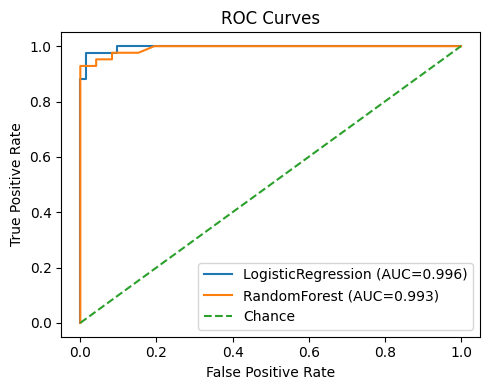

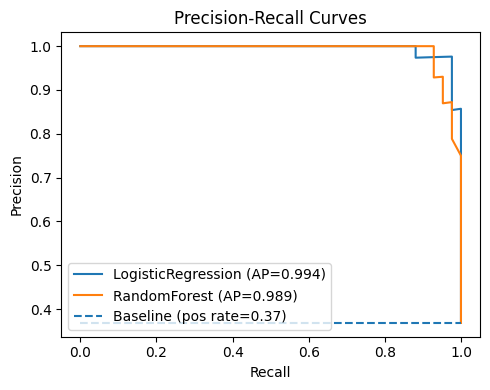

In [16]:

def plot_roc_pr(y_test, results_dicts):
    # ROC curves
    plt.figure(figsize=(5,4))
    for res in results_dicts:
        fpr, tpr, _ = roc_curve(y_test, res['probs'])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label=f"{res['name']} (AUC={roc_auc:.3f})")
    plt.plot([0,1],[0,1],'--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves')
    plt.legend()
    plt.tight_layout()
    plt.show()

    # Precision-Recall curves
    plt.figure(figsize=(5,4))
    for res in results_dicts:
        precision, recall, _ = precision_recall_curve(y_test, res['probs'])
        ap = average_precision_score(y_test, res['probs'])
        plt.plot(recall, precision, label=f"{res['name']} (AP={ap:.3f})")
    baseline = y_test.mean()
    plt.hlines(baseline, 0, 1, linestyles='--', label=f'Baseline (pos rate={baseline:.2f})')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curves')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_roc_pr(y_test, [lr_test, rf_test])


## 6) Probability Calibration (Platt & Isotonic) + Reliability Curves + Brier Score

<Figure size 500x400 with 0 Axes>

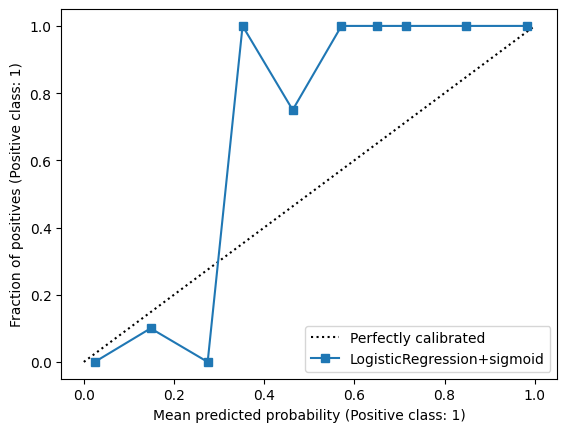

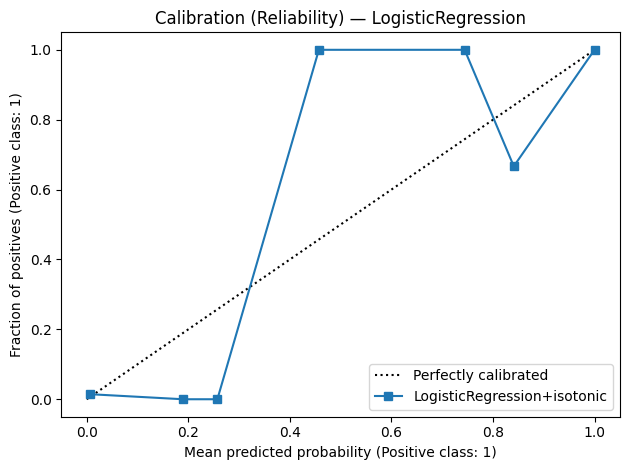

LogisticRegression+sigmoid Brier Score: 0.0314
LogisticRegression+isotonic Brier Score: 0.0208


In [18]:

def calibrate_and_plot(base_estimator, X_train, y_train, X_test, y_test, name='Model'):
    """Fit Platt (sigmoid) and Isotonic calibration and plot reliability curves; print Brier scores."""
    calib_methods = ['sigmoid','isotonic']
    results = []
    plt.figure(figsize=(5,4))
    for method in calib_methods:
        calib = CalibratedClassifierCV(base_estimator, method=method, cv=5)
        calib.fit(X_train, y_train)
        prob = calib.predict_proba(X_test)[:,1]
        brier = brier_score_loss(y_test, prob)
        results.append((method, brier, prob))
        CalibrationDisplay.from_predictions(y_test, prob, n_bins=10, strategy='uniform', name=f'{name}+{method}')
    plt.title(f'Calibration (Reliability) — {name}')
    plt.tight_layout()
    plt.show()
    for method, brier, _ in results:
        print(f'{name}+{method} Brier Score: {brier:.4f}')
    return results

# Choose the better of LR/RF by test ROC for calibration
base_choice = best_rf.best_estimator_ if rf_test['roc'] >= lr_test['roc'] else best_lr.best_estimator_
base_name = 'RandomForest' if rf_test['roc'] >= lr_test['roc'] else 'LogisticRegression'
calib_results = calibrate_and_plot(base_choice, X_train, y_train, X_test, y_test, name=base_name)


## 7) Decision Curve Analysis (DCA)

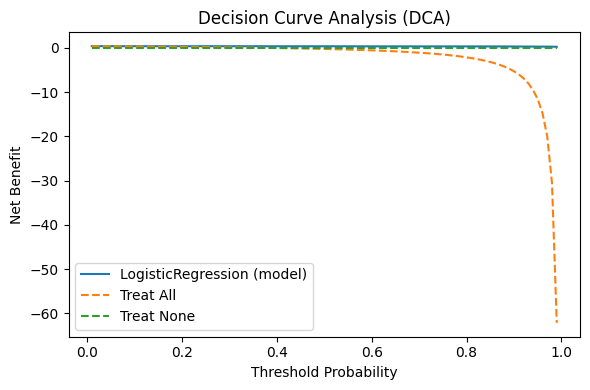

In [20]:

def net_benefit(y_true, y_prob, thresholds):
    """Compute net benefit across thresholds for a binary classifier.
    NB = (TP/N) - (FP/N) * (pt/(1-pt))
    """
    N = len(y_true)
    y_true = np.array(y_true)
    nb = []
    for pt in thresholds:
        y_pred = (y_prob >= pt).astype(int)
        TP = np.sum((y_pred==1) & (y_true==1))
        FP = np.sum((y_pred==1) & (y_true==0))
        nb.append((TP/N) - (FP/N) * (pt/(1-pt)))
    return np.array(nb)

# Use the base (uncalibrated) model probabilities chosen above
probs_for_dca = rf_test['probs'] if base_name=='RandomForest' else lr_test['probs']

# Threshold grid
thresholds = np.linspace(0.01, 0.99, 99)

# Net benefit curves
nb_model = net_benefit(y_test, probs_for_dca, thresholds)
pos_rate = y_test.mean()
nb_treat_all = pos_rate - (1 - pos_rate) * (thresholds/(1-thresholds))
nb_treat_none = np.zeros_like(thresholds)

plt.figure(figsize=(6,4))
plt.plot(thresholds, nb_model, label=f'{base_name} (model)')
plt.plot(thresholds, nb_treat_all, '--', label='Treat All')
plt.plot(thresholds, nb_treat_none, '--', label='Treat None')
plt.xlabel('Threshold Probability')
plt.ylabel('Net Benefit')
plt.title('Decision Curve Analysis (DCA)')
plt.legend()
plt.tight_layout()
plt.show()


## 8) DNN (Keras preferred; sklearn MLP fallback)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
[Keras-DNN] Acc=0.974 Prec=0.976 Rec=0.952 F1=0.964 ROC-AUC=0.996


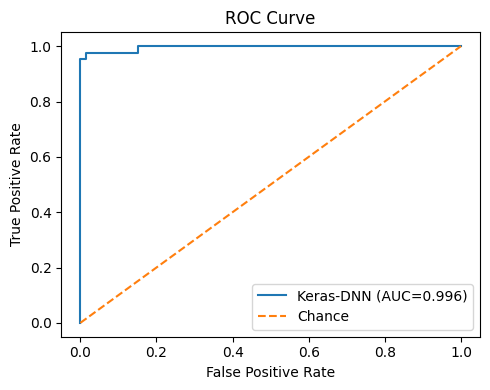

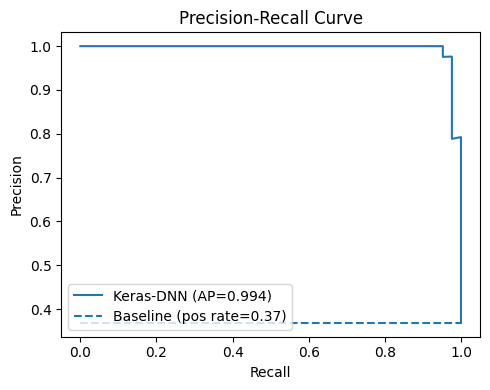

In [22]:

def evaluate_probs(name, y_true, y_prob):
    """Utility to compute standard metrics from probabilities (threshold=0.5 for class labels)."""
    y_pred = (y_prob >= 0.5).astype(int)
    acc = accuracy_score(y_true, y_pred)
    prec = precision_score(y_true, y_pred)
    rec = recall_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    roc = roc_auc_score(y_true, y_prob)
    print(f'[{name}] Acc={acc:.3f} Prec={prec:.3f} Rec={rec:.3f} F1={f1:.3f} ROC-AUC={roc:.3f}')
    return {'name':name, 'acc':acc, 'prec':prec, 'rec':rec, 'f1':f1, 'roc':roc, 'probs':y_prob, 'pred':y_pred}

dnn_result = None
if TF_AVAILABLE:
    # Build a simple Keras MLP with early stopping
    from tensorflow.keras import Sequential
    from tensorflow.keras.layers import Dense, Dropout
    from tensorflow.keras.callbacks import EarlyStopping

    scaler = StandardScaler().fit(X_train)
    X_train_s = scaler.transform(X_train)
    X_test_s  = scaler.transform(X_test)

    model = Sequential([
        Dense(32, activation='relu', input_shape=(X_train_s.shape[1],)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

    es = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X_train_s, y_train.values, validation_split=0.2,
        epochs=200, batch_size=32, callbacks=[es], verbose=0
    )

    y_prob_dnn = model.predict(X_test_s).ravel()
    dnn_result = evaluate_probs('Keras-DNN', y_test.values, y_prob_dnn)
    # Plot ROC/PR for DNN
    def plot_roc_pr_single(y_true, probs, name='Model'):
        fpr, tpr, _ = roc_curve(y_true, probs)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
        plt.plot([0,1],[0,1],'--', label='Chance')
        plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve'); plt.legend(); plt.tight_layout(); plt.show()

        precision, recall, _ = precision_recall_curve(y_true, probs)
        ap = average_precision_score(y_true, probs)
        plt.figure(figsize=(5,4))
        plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")
        baseline = np.mean(y_true)
        plt.hlines(baseline, 0, 1, linestyles='--', label=f'Baseline (pos rate={baseline:.2f})')
        plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve'); plt.legend(); plt.tight_layout(); plt.show()
    plot_roc_pr_single(y_test.values, y_prob_dnn, name='Keras-DNN')
else:
    # Fallback: sklearn MLP with early stopping
    pipe_mlp = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', MLPClassifier(hidden_layer_sizes=(32,16), activation='relu', max_iter=1000,
                              random_state=SEED, early_stopping=True))
    ])
    pipe_mlp.fit(X_train, y_train)
    y_prob_mlp = pipe_mlp.predict_proba(X_test)[:,1]
    dnn_result = evaluate_probs('Sklearn-MLP', y_test, y_prob_mlp)
    # Plot ROC/PR for MLP
    def plot_roc_pr_single(y_true, probs, name='Model'):
        fpr, tpr, _ = roc_curve(y_true, probs)
        roc_auc = auc(fpr, tpr)
        plt.figure(figsize=(5,4))
        plt.plot(fpr, tpr, label=f"{name} (AUC={roc_auc:.3f})")
        plt.plot([0,1],[0,1],'--', label='Chance')
        plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title('ROC Curve'); plt.legend(); plt.tight_layout(); plt.show()

        precision, recall, _ = precision_recall_curve(y_true, probs)
        ap = average_precision_score(y_true, probs)
        plt.figure(figsize=(5,4))
        plt.plot(recall, precision, label=f"{name} (AP={ap:.3f})")
        baseline = np.mean(y_true)
        plt.hlines(baseline, 0, 1, linestyles='--', label=f'Baseline (pos rate={baseline:.2f})')
        plt.xlabel('Recall'); plt.ylabel('Precision'); plt.title('Precision-Recall Curve'); plt.legend(); plt.tight_layout(); plt.show()
    plot_roc_pr_single(y_test, y_prob_mlp, name='Sklearn-MLP')


## 9) XAI — SHAP for RF (Permutation Importance Fallback)

[INFO] Using feature space with 30 features. Xtr=(455, 30), Xte=(114, 30)
shap version: 0.45.1

[SHAP] Summary (dot) — Fig. 8 style


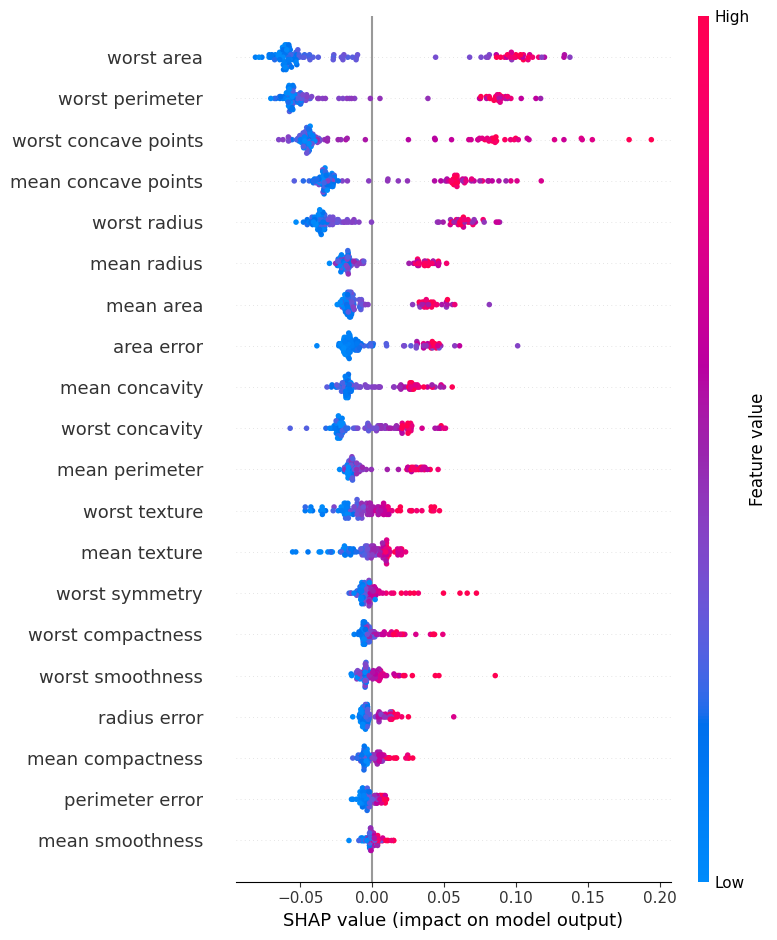

[INFO] Chosen malignant-like idx=1, p=1.000 | benign-like idx=25, p=0.000

[FORCE] malignant-like (clean)


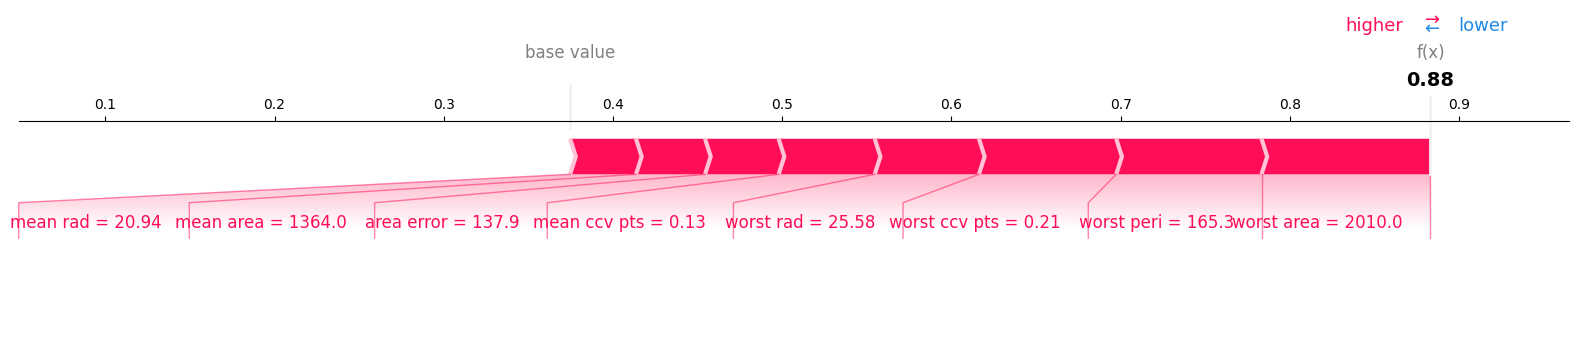

<Figure size 3080x616 with 0 Axes>


[FORCE] benign-like (clean)


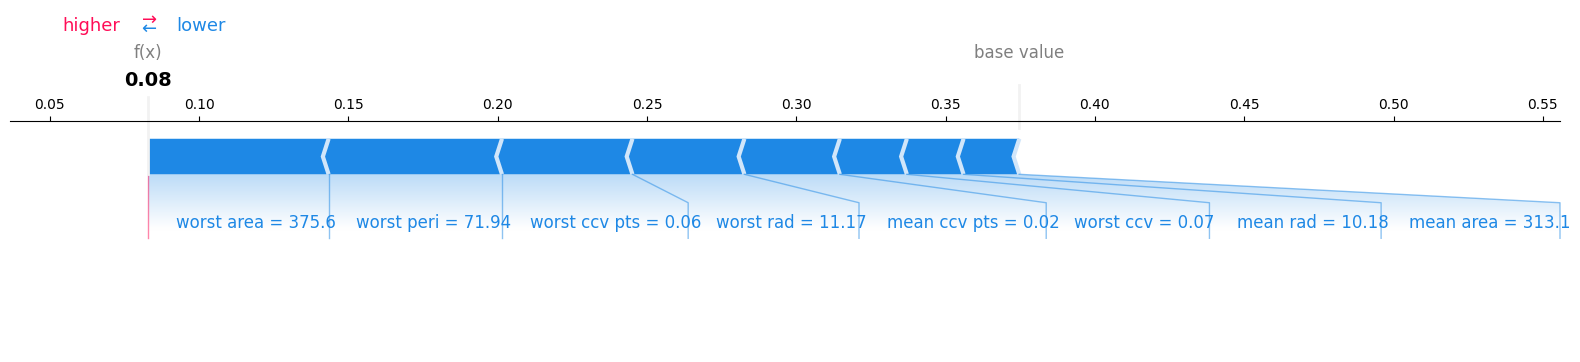

<Figure size 3080x616 with 0 Axes>

[SHAP] Waterfall — malignant-like example (top-12)


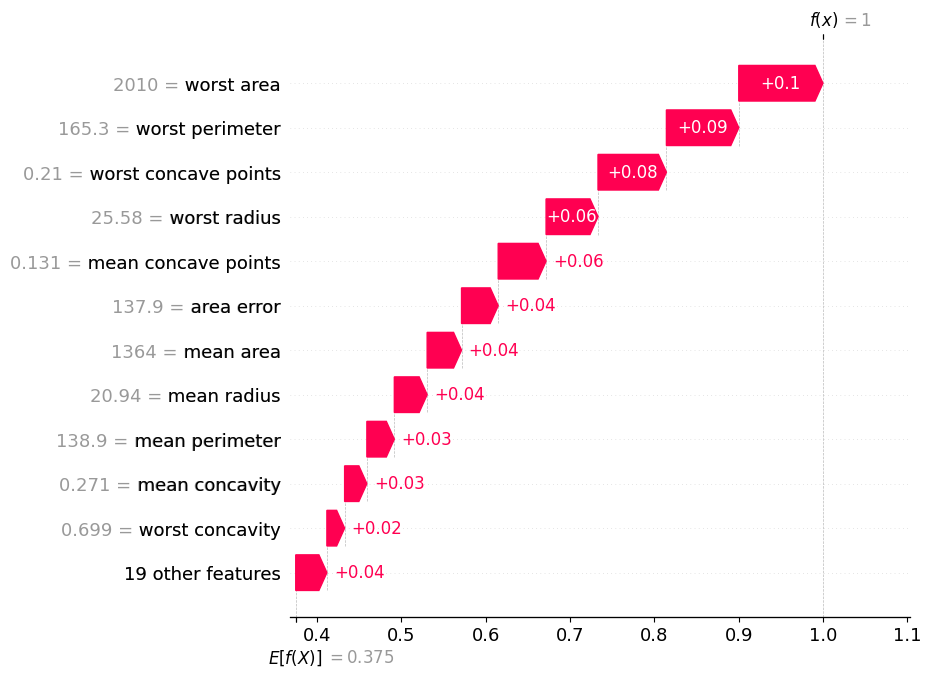

[SHAP] Waterfall — benign-like example (top-12)


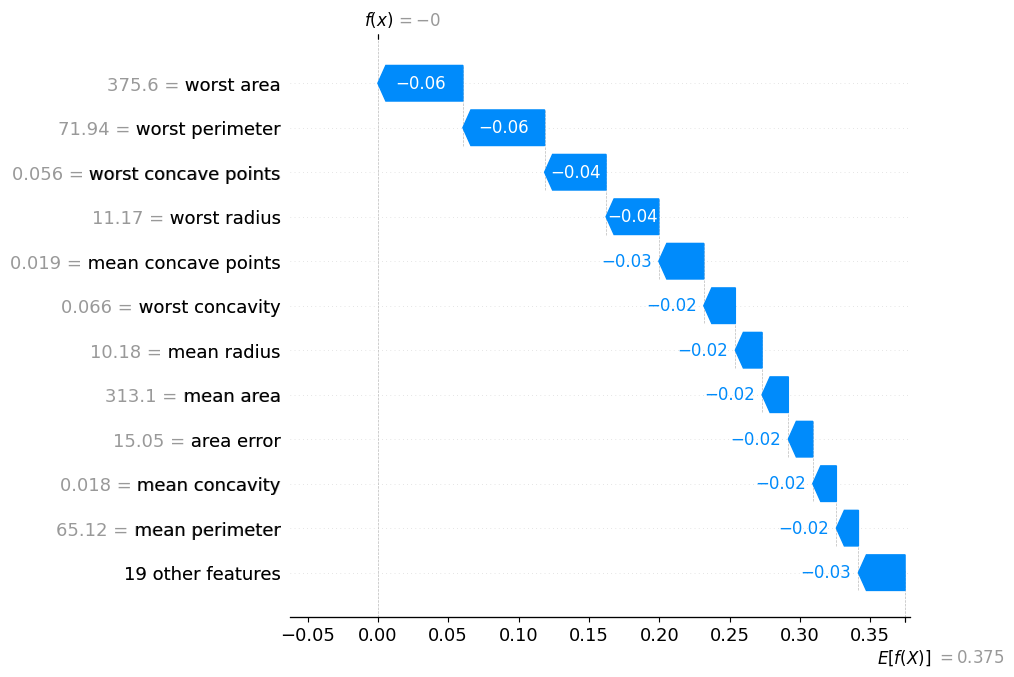


[SHAP] Dependence: 'worst area' colored by 'worst perimeter'


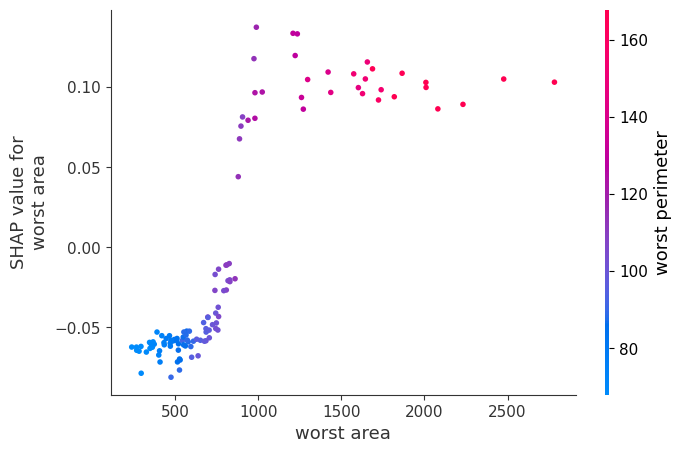

Saved interactive HTML: force_malignant_example.html


In [70]:


import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier

# 0) Consistent feature space (use top-20 if present, else all 30)
if all(v in globals() for v in ['X_train_fs','X_test_fs','selected_cols']):
    Xtr, Xte = np.asarray(X_train_fs), np.asarray(X_test_fs)
    feat_names = list(selected_cols)
else:
    Xtr, Xte = np.asarray(X_train), np.asarray(X_test)
    feat_names = list(X_train.columns)

print(f"[INFO] Using feature space with {len(feat_names)} features. Xtr={Xtr.shape}, Xte={Xte.shape}")

# 1) Train a clean RF on THIS space (avoids any mismatch)
SEED = 42
rf = RandomForestClassifier(n_estimators=300, random_state=SEED)
rf.fit(Xtr, y_train)

# 2) SHAP computation (handles list/Explanation/2D/3D outputs)
import shap
print("shap version:", shap.__version__)
explainer = shap.TreeExplainer(rf)
shap_out = explainer.shap_values(Xte)
exp_val  = explainer.expected_value  # can be list/array/scalar

def pick_expected_value(ev):
    """Return scalar expected value for positive class (1=malignant)."""
    if isinstance(ev, (list, np.ndarray)):
        ev = np.atleast_1d(ev)
        return ev[1] if len(ev) > 1 else ev[0]
    return ev

def shap_to_matrix(shap_result, n_features):
    """
    Normalize SHAP output to a 2D matrix (n_samples, n_features) for positive class.
    Handles: list([class0, class1]), Explanation, 3D arrays (n, p, 2), and transposed shapes.
    """
    # List case: [class0, class1]
    if isinstance(shap_result, list):
        M = np.array(shap_result[1])
    # Explanation object
    elif hasattr(shap_result, "values"):
        M = np.array(shap_result.values)
    else:
        M = np.array(shap_result)

    # If 3D with last dim=2 (per-class), take positive class
    if M.ndim == 3 and M.shape[-1] == 2:
        M = M[..., 1]
    # If transposed (p, n), fix orientation
    if M.ndim == 2 and M.shape[0] == n_features and M.shape[1] != n_features:
        M = M.T
    if M.ndim != 2 or M.shape[1] != n_features:
        raise ValueError(f"Unexpected SHAP shape {M.shape} for {n_features} features")
    return M

pos_vals = shap_to_matrix(shap_out, n_features=len(feat_names))
ev = pick_expected_value(exp_val)

# 3) SUMMARY (dot) — Fig. 8 style
print("\n[SHAP] Summary (dot) — Fig. 8 style")
shap.summary_plot(pos_vals, Xte, feature_names=feat_names, show=True)

# 4) Choose a strongly malignant-like and benign-like test instance for force & waterfall
probs = rf.predict_proba(Xte)[:, 1]  # P(class=1 = malignant)
idx_pos = int(np.argmax(probs))      # most malignant-like -> red/right
idx_neg = int(np.argmin(probs))      # most benign-like    -> blue/left
print(f"[INFO] Chosen malignant-like idx={idx_pos}, p={probs[idx_pos]:.3f} | benign-like idx={idx_neg}, p={probs[idx_neg]:.3f}")

# 5) FORCE PLOTS — Fig. 9 style (static, matplotlib)

import numpy as np
import matplotlib.pyplot as plt

# --- Shorten feature names to avoid long labels ---
def short_names(names):
    out = []
    for s in names:
        s2 = (s.replace('fractal_dimension','fracdim')
                .replace('concave points','ccv pts')
                .replace('concavity','ccv')
                .replace('compactness','comp')
                .replace('perimeter','peri')
                .replace('radius','rad')
                .replace('texture','tex')
                .replace('smoothness','smooth')
                .replace('symmetry','sym')
                .replace('_worst','_w')
                .replace('_mean','_m')
                .replace('_se','_se'))
        out.append(s2)
    return out

# --- Clean force plot: top-K only + rounded values + bigger figure ---
def force_plot_paper(idx, shap_vals, X_array, feat_names, base_value, top_k=8, round_digits=2):
    """
    idx        : index of the test instance to visualize
    shap_vals  : 2D array (n_samples, n_features) for positive class
    X_array    : 2D array of features (same shape as used for SHAP)
    feat_names : list of feature names
    base_value : expected value (scalar) for positive class
    top_k      : show only the K strongest contributions (keeps plot readable)
    round_digits : round feature values in labels to keep them short
    """
    v = shap_vals[idx].copy()

    # keep only top_k absolute contributions (others -> 0 so their labels disappear)
    order = np.argsort(np.abs(v))[::-1]
    keep = order[:min(top_k, len(order))]
    mask = np.ones_like(v, dtype=bool)
    mask[keep] = False
    v[mask] = 0.0

    # shorter names + rounded feature values (labels shorter)
    fn_short = short_names(feat_names)
    x_row = X_array[idx].copy()
    x_row = np.round(x_row, round_digits)

    # plot with matplotlib backend
    shap.force_plot(base_value, v, x_row, feature_names=fn_short, matplotlib=True)

    # enlarge the canvas and increase DPI so text has room
    fig = plt.gcf()
    fig.set_size_inches(14, 2.8)  # width x height
    fig.set_dpi(220)
    plt.tight_layout()
    plt.show()


# ev: expected value (pozitif sınıf), pos_vals: SHAP katkıları (n_test x n_feat), Xte: test özellikleri, feat_names: isimler
print("\n[FORCE] malignant-like (clean)")
force_plot_paper(idx_pos, pos_vals, Xte, feat_names, ev, top_k=8, round_digits=2)

print("\n[FORCE] benign-like (clean)")
force_plot_paper(idx_neg, pos_vals, Xte, feat_names, ev, top_k=8, round_digits=2)



# 6) WATERFALL plots (clean, publication-friendly)
def waterfall_from_idx(idx, title="SHAP Waterfall"):
    exp = shap.Explanation(
        values=pos_vals[idx],
        base_values=ev,
        data=Xte[idx],
        feature_names=feat_names
    )
    print(title)
    shap.plots.waterfall(exp, max_display=12)  # top-12 contributions
    plt.show()

waterfall_from_idx(idx_pos, title="[SHAP] Waterfall — malignant-like example (top-12)")
waterfall_from_idx(idx_neg, title="[SHAP] Waterfall — benign-like example (top-12)")

# 7) Optional: Dependence/interaction for top features
# --- Dependence / interaction: version-robust call ---

top_feat = feat_names[order[0]]
color_feat = feat_names[order[1]] if len(order) > 1 else None
print(f"\n[SHAP] Dependence: '{top_feat}' colored by '{color_feat}'")

try:
    # Legacy / classic API (works on many versions)
    shap.dependence_plot(
        top_feat,                # feature name (or index)
        pos_vals,                # SHAP values (n_samples x n_features)
        Xte,                     # raw feature matrix
        feature_names=feat_names,
        interaction_index=color_feat,   # <— key change: use kwarg instead of tuple
        show=True
    )
except Exception as e:
    print("[INFO] dependence_plot fell back to new API. Reason:", e)
    # New-style API using Explanation object
    exp = shap.Explanation(
        values=pos_vals,
        base_values=np.repeat(ev, pos_vals.shape[0]),
        data=Xte,
        feature_names=feat_names
    )
    if color_feat:
        shap.plots.scatter(exp[:, top_feat], color=exp[:, color_feat], show=True)
    else:
        shap.plots.scatter(exp[:, top_feat], show=True)

# 8) Optional: Save interactive (HTML) force plot for malignant example (no label overlap in browser)
try:
    html = shap.force_plot(ev, pos_vals[idx_pos, :], Xte[idx_pos, :], feature_names=feat_names)
    shap.save_html("force_malignant_example.html", html)
    print("Saved interactive HTML:", "force_malignant_example.html")
except Exception as e:
    print("[WARN] HTML force plot save failed:", e)


## 10) XAI — LIME for DNN (Single Instance)

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


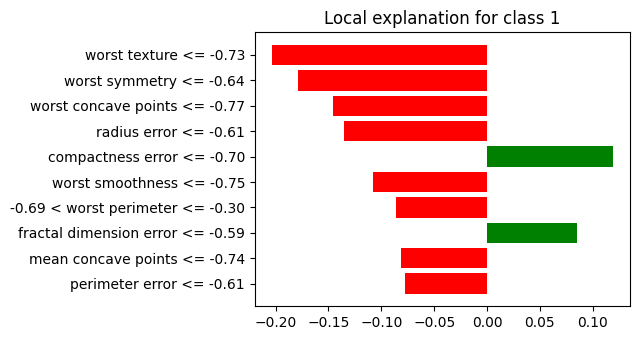

,Feature,Value,Weight
0,worst texture,16.94,-0.204
1,worst symmetry,0.23,-0.179
2,worst concave points,0.02,-0.146
3,radius error,0.22,-0.135
4,compactness error,0.00,0.119
5,worst smoothness,0.09,-0.108
6,worst perimeter,95.48,-0.086
7,fractal dimension error,0.00,0.085
8,mean concave points,0.00,-0.081
9,perimeter error,1.51,-0.077


In [60]:
# --- LIME figure ---

import numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier

# 1) Choose model to explain and input representation
USE_TF = 'tf' in globals() and TF_AVAILABLE if 'TF_AVAILABLE' in globals() else False

if USE_TF and 'model' in globals():
    # Keras DNN path (scale inputs)
    scaler_lime = StandardScaler().fit(X_train)
    X_train_expl = scaler_lime.transform(X_train)
    X_test_expl  = scaler_lime.transform(X_test)

    def predict_proba_fn(x):
        # return 2-column probs for classes [0,1]
        p1 = model.predict(x).ravel()
        return np.vstack([1 - p1, p1]).T

else:
    # Fallback: a compact sklearn MLP pipeline 
    clf_pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('clf', MLPClassifier(hidden_layer_sizes=(32,16), activation='relu',
                              max_iter=1000, random_state=42, early_stopping=True))
    ]).fit(X_train, y_train)

    # For sklearn pipelines, no extra scaling outside:
    X_train_expl = X_train.values
    X_test_expl  = X_test.values

    def predict_proba_fn(x):
        return clf_pipe.predict_proba(x)

# 2) Build LIME explainer 
from lime.lime_tabular import LimeTabularExplainer
explainer = LimeTabularExplainer(
    training_data=X_train_expl,
    feature_names=X_train.columns.tolist(),
    class_names=['0','1'],          # 0=benign, 1=malignant (labels as strings like the paper)
    discretize_continuous=True,
    mode='classification',
    random_state=42
)

# 3) Pick the 100th test patient (index 99) to match the caption
idx = min(99, len(X_test_expl)-1)

# 4) Explain this instance for class 1 (malignant)
exp = explainer.explain_instance(
    data_row=X_test_expl[idx],
    predict_fn=predict_proba_fn,
    num_features=10,
    top_labels=2
)

# 5) Render the paper-like matplotlib figure (bars + probability box)
#    IMPORTANT: pass label=1 so the orange (positive) bars are for class 1
fig = exp.as_pyplot_figure(label=1)
fig.set_size_inches(6.5, 3.5)   # tweak size to your page
plt.tight_layout()
plt.show()

# 6) Build the "Feature–Value" table on the right (like the screenshot)
#    We take the actual (possibly scaled) values for readability; you can swap in raw X_test if you prefer.
pairs = exp.as_list(label=1)  # list of (rule_str, weight)
feat_names = []
for rule,_ in pairs:
    # LIME rule strings look like: 'texture_worst > 0.69' or 'radius_se <= -0.61'
    # Extract the feature name before first space or comparator sign
    # Be robust to different formats:
    tok = rule.replace('<',' ').replace('>',' ').replace('=',' ').split()
    feat_names.append(tok[0])

# map feature names to their actual values (use original X_test to show unscaled values if you want)
# --- Build the Feature–Value table ROBUSTLY (no string parsing) ---


label = 1

available = list(exp.as_map().keys())
if label not in available and str(label) in available:
    label = str(label)

#  [(feature_index, weight), ...]
pairs_idx = exp.as_map()[label]   # already sorted by |weight|
feat_idx  = [i for i, _ in pairs_idx]
weights   = [w for _, w in pairs_idx]

# 3) get from DataFrame(UNSCALED raw X_test)
feat_names_ordered = [X_train.columns[i] for i in feat_idx]
feat_values_raw    = [X_test.iloc[idx, i] for i in feat_idx]

table_df = pd.DataFrame({
    'Feature': feat_names_ordered,
    'Value':   np.round(feat_values_raw, 2),
    'Weight':  np.round(weights, 3)
})

display(table_df)

